### Notebook for the `NicheCompass` exploratory analysis of 10X Genomics Xenium for BRCA  

- **Developed by**: Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology (WüSI) & Julius-Maximilian-Universität Würzburg**
- **Created**: 230620
- **Last modified**: 230905

### Load required packages

In [1]:
import anndata
import numpy as np
import scanpy as sc
import pandas as pd
import squidpy as sq
import seaborn as sns
import networkx as nx
from pywaffle import Waffle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pybiomart import Server, Dataset
from pyveplot import Hiveplot, Axis, Node

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


### Set up wortking environment 

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'magma', dpi_save = 400, vector_friendly = True, format = 'svg', fontsize = 8)

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                         10.0.0
appnope                     0.1.3
asciitree                   NA
asttokens                   NA
attr                        23.1.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cattr                       NA
cattrs                      NA
certifi                     2023.07.22
charset_normalizer          3.2.0
cloudpickle                 2.2.1
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dask                        2023.9.0
dask_image                  2023.08.1
datashader                  0.15.2
datashape                   0.5.2
datatree                    0.0.12
dateutil                    2.8.2
debugpy                     1.6.7.post1
decorator                   5.1.1
docrep                      0.3.2
entrypoints                 0.4
exceptiongroup              1.1.3
executing                   1.2.0


In [3]:
color_palette = sns.color_palette("Paired", 26)

### Read in Xenium dataset

In [4]:
adata = sc.read("../../datasets/xenium_human_breast_cancer_analysis.h5ad")
adata

AnnData object with n_obs × n_vars = 282363 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'replicates', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes', 'leiden', 'cell_states', 'batch', 'CXCL12_ligand_receptor_GP', 'CD8A_ligand_receptor_GP', 'CD80_ligand_receptor_GP', 'CD8B_ligand_receptor_GP', 'Abca1_ligand_receptor_target_gene_GP', 'Ace2_ligand_receptor_target_gene_GP', 'Adam17_ligand_receptor_target_gene_GP', 'Adam2_ligand_receptor_target_gene_GP', 'Adgrb1_ligand_receptor_target_gene_GP', 'Adm2_ligand_receptor_target_gene_GP', 'Ahsg_ligand_receptor_target_gene_GP', 'Ang_ligand_receptor_target_gene_GP', 'Ang2_ligand_receptor_target_gene_GP', 'Ang4_ligand_receptor_target_gene_GP', 'Ang5_ligand_recep

/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/cartalop/mambaforge/envs/squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


KeyError: 'Could not find key niche in .var_names or .obs.columns.'

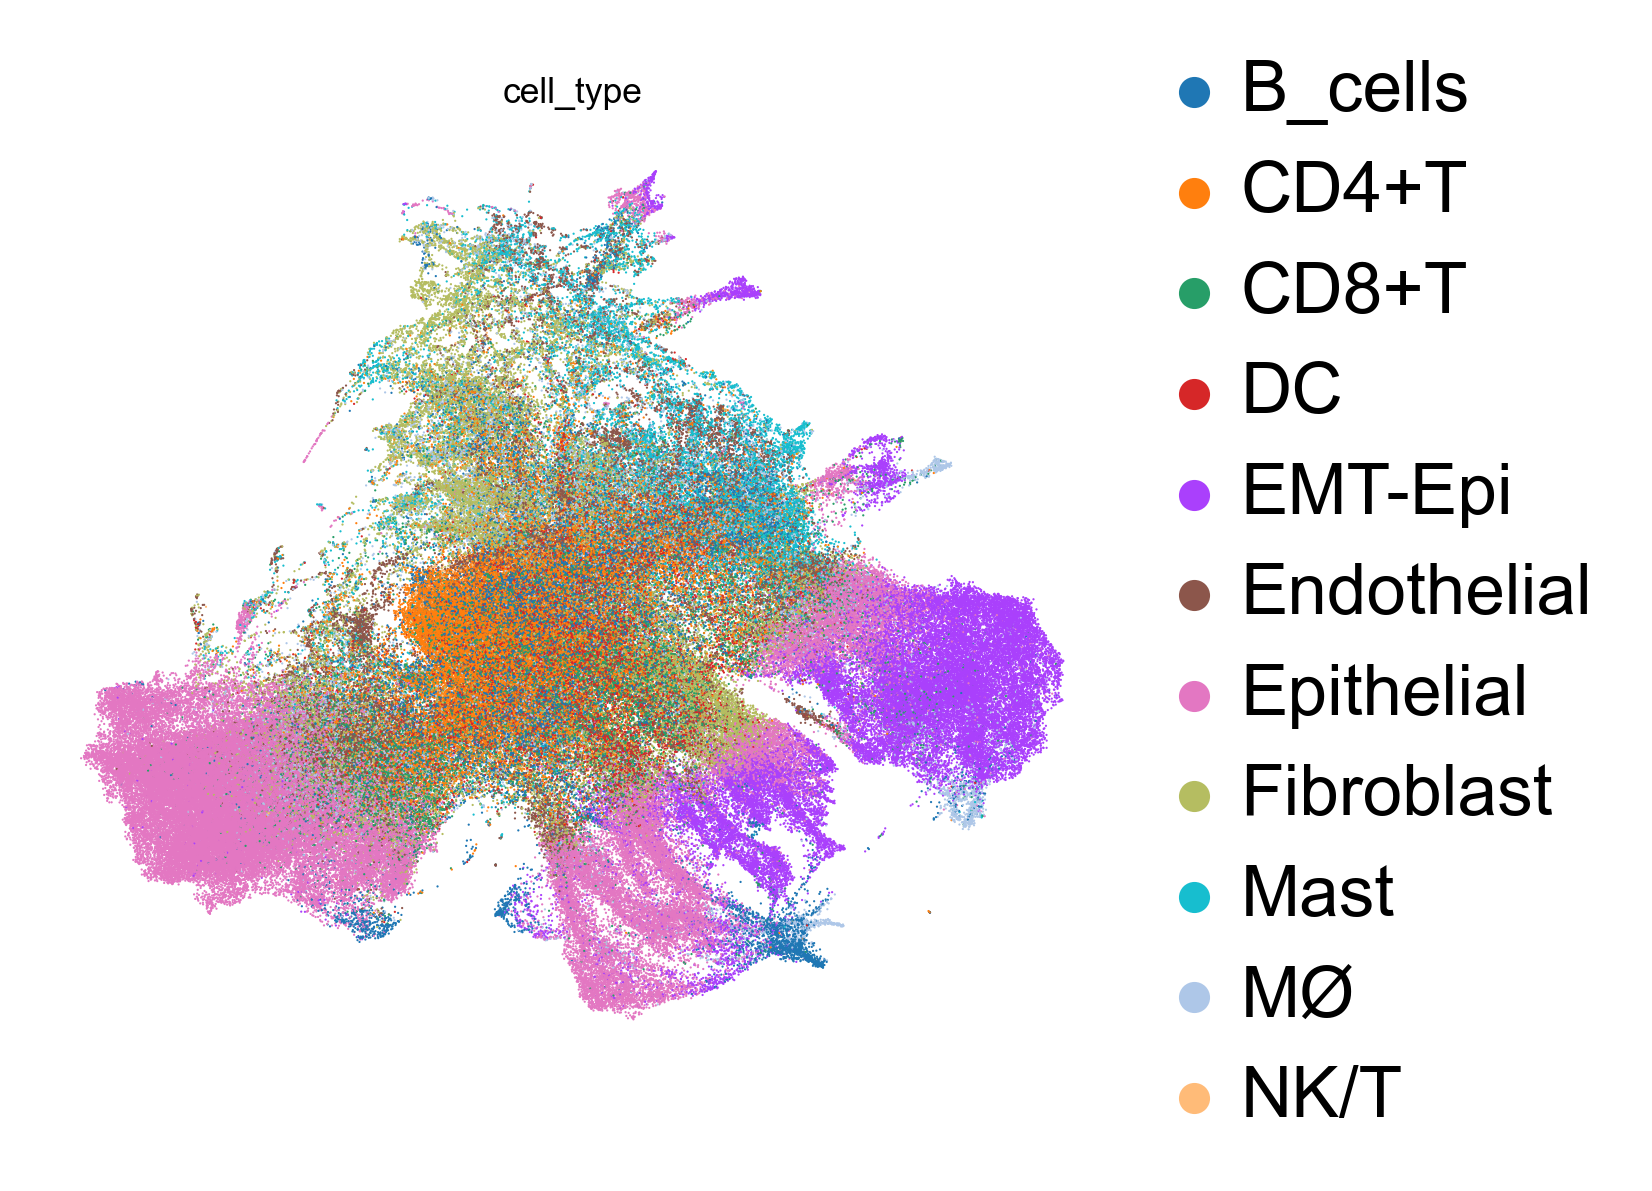

In [7]:
sc.pl.umap(
    adata,
    color = ["cell_type", "niche", "replicates"],
    wspace = 0.4,
    frameon = False, 
    size = 1,
    legend_fontsize = 16,
    ncols = 2
)

### Rename cell types

In [6]:
trans_from=[['Epi_ABCC11+', 'Epi_FOXA1+', 'Epi_AGR3+', 'Epi_CENPF+', 'mgEpi_KRT14+', 'Epi_KRT14+'],['EC_CLEC14A+', 'EC_CAVIN2+'],['adipo_FB', 'GJB2+iKC-FB'],['EMT-Epi1_CEACAM6+', 'EMT-Epi2_CEACAM6+', 'EMT-Epi_SERPINA3+', 'EMT-Epi_KRT23+'],['DERL3+B', 'BANK1+B', 'B'],['eff_CD8+T1', 'eff_CD8+T2',],['tcm_CD4+T', 'CD161+FOXP3+T'],['NK/T'],['ADIPOQ+Mast'],['M2MØ', 'MMP12+miMØ'], ['DC1']]
trans_to = ['Epithelial', 'Endothelial', 'Fibroblast', 'EMT-Epi', 'B_cells', 'CD8+T', 'CD4+T', 'NK/T', 'Mast', 'MØ', 'DC']

adata.obs['cell_type'] = [str(i) for i in adata.obs['cell_states']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        adata.obs['cell_type'][adata.obs['cell_type'] == leiden_from] = celltype

/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_70696/186565815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type'][adata.obs['cell_type'] == leiden_from] = celltype
/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_70696/186565815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type'][adata.obs['cell_type'] == leiden_from] = celltype
/var/folders/j1/l8rz6t7953z7vlpdytk0pbv40000gn/T/ipykernel_70696/186565815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

### Visualise cellular proportions per niche

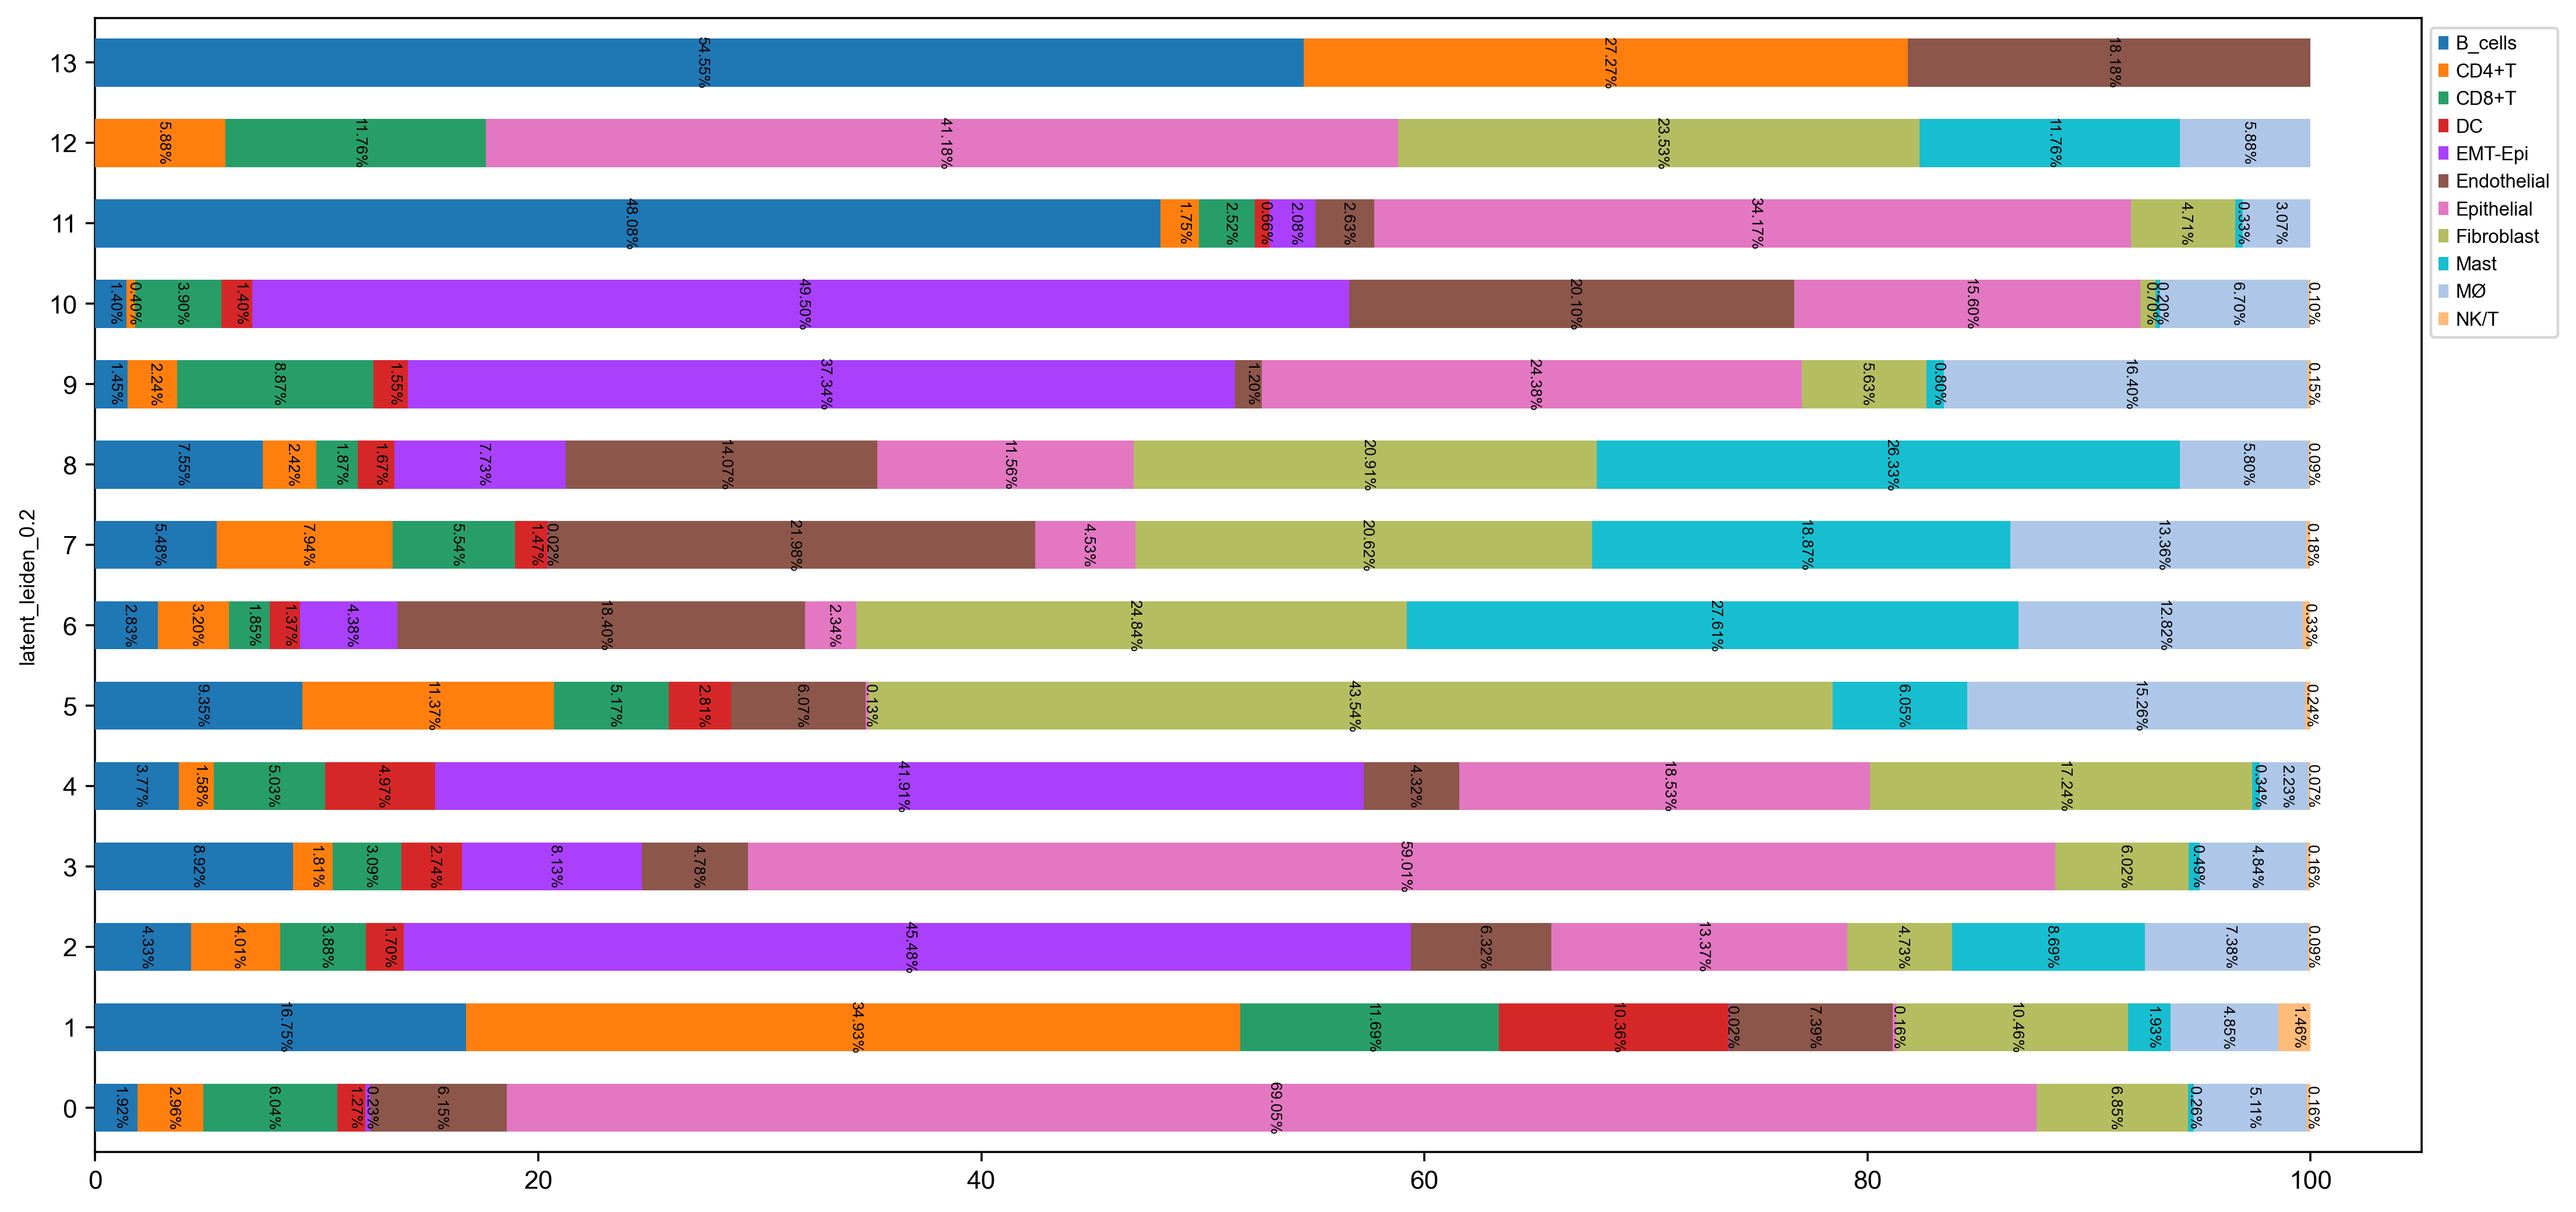

In [8]:
data = pd.crosstab(adata.obs['latent_leiden_0.2'], adata.obs['cell_type'])
totals = data.sum(axis = 1)
percent = data.div(totals, axis = 0).mul(100).round(2)

ax1 = percent.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (16,8), fontsize = 10, grid = False, width = 0.6)
horiz_offset = 1.0
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 1)

for c in ax1.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{w:0.2f}%' if (w := v.get_width()) > 0 else '' for v in c]
    
    # add annotations
    ax1.bar_label(c, labels = labels, label_type = 'center', padding = 1, color = 'black', rotation = 270, fontsize = 6)

In [9]:
adata.obs['latent_leiden_0.2'].value_counts()

latent_leiden_0.2
0     76031
1     70339
2     52530
3     23037
4     18821
5     14043
6     11650
7      8497
8      3468
9      2006
10     1000
11      913
12       17
13       11
Name: count, dtype: int64

In [10]:
adata.obs['niche'] = adata.obs['latent_leiden_0.2'].copy()
adata.obs['niche'] = adata.obs['niche'].cat.rename_categories(['Stromal_1', 'CD4+T', 'EMT-Immune', 'Epi-Immune', 'EMT-FB', 'FB-Immune', 'Mast-FB_1', 'Endo-FB', 'Mast-FB_2', 'EMT-MØ', 'EMT-Endo', 'Epi-Bcells', 'Stromal', 'Endo-Lymphoid'])
sq.pl.spatial_scatter(adata, color = ["cell_type", "niche"], shape = None, size = 0.2, frameon = False)

ValueError: new categories need to have the same number of items as the old categories!

### Visualise cell types and niches in replicate 1

In [ ]:
adata.obs['replicates'].cat.categories

In [ ]:
adata_1_ann = adata[adata.obs['replicates'].isin(['Rep_1'])]
adata_1_ann

In [ ]:
sq.pl.spatial_scatter(adata_1_ann, color = ["cell_type", "niche"], 
shape = None, 
size = 0.1, 
alpha = 0.95, 
frameon = False, 
legend_fontsize = 12,
figsize = (8,8),
cmap = 'RdBu_r')

### Visualise replicate #2

In [ ]:
adata_2_ann = adata[adata.obs['replicates'].isin(['Rep_2'])]
adata_2_ann

In [ ]:
sq.pl.spatial_scatter(adata_2_ann, color = ["cell_type", "niche"], 
shape = None, 
size = 0.1, 
alpha = 0.95, 
frameon = False, 
legend_fontsize = 12,
figsize = (8,8),
cmap = 'RdBu_r')

### Generate waffle plot per niche

In [ ]:
adata_subset = adata[adata.obs['niche'].isin(['Immune_Str', 'EMT-Epi', 'Myeloid_Stromal', 'Lymphoid'])]

In [ ]:
df = adata_subset.obs.groupby(['niche', 'cell_type']).size().reset_index(name = 'counts')

df['proportions'] = df.groupby('niche')['counts'].transform(lambda x: x / x.sum() * 100)
df['waffle_counts'] = (df['proportions'] * 10).astype(int)

In [ ]:
tab20_palette = plt.cm.get_cmap('tab20', len(df['cell_type'].unique()))


for group in df['niche'].unique():
    temp_df = df[df['niche'] == group]
    
    data = dict(zip(temp_df['cell_type'], temp_df['waffle_counts']))
    colors = [tab20_palette(i) for i in range(len(temp_df['cell_type']))]
    fig = plt.figure(
        FigureClass = Waffle, 
        rows = 10, 
        values = data, 
        title = {'label': f'Niche {group}', 'loc': 'left', 'fontsize': 14},
        labels = [f"{k} ({v}%)" for k, v in zip(temp_df['cell_type'], temp_df['proportions'].round(2))],
        #legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
        legend = {'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0, 'fontsize': 16},
        figsize = (40, 4),
        colors = colors
    )
    plt.show()

### Format object for pathway scores calculation

In [ ]:
adata_log = anndata.AnnData(X = adata.X,  var = adata.var, obs = adata.obs, obsm = adata.obsm, uns = adata.uns, varm = adata.varm, layers = adata.layers, obsp = adata.obsp)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)
adata_log.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_log, inplace = False)["X"])
adata_log

### Visualise GP activity

In [ ]:
adata_log

In [ ]:
specific_gps = ['Ethanol_metabolite_enzyme_sensor_GP',
'Vitamin_A_metabolite_enzyme_sensor_GP',
'ADIPOQ_ligand_receptor_GP',
'Testosterone_metabolite_enzyme_sensor_GP',
'Androstenedione_metabolite_enzyme_sensor_GP',
'CCL20_ligand_receptor_GP',
'CCL5_ligand_receptor_target_gene_GP',
'CCL5_ligand_receptor_GP',
'CD80_ligand_receptor_GP',
'CDH1_ligand_receptor_target_gene_GP',
'CEACAM6_ligand_receptor_target_gene_GP',
'CSF3_ligand_receptor_GP',
'L-Cysteine_metabolite_enzyme_sensor_GP',
'Hydrogen_sulfide_metabolite_enzyme_sensor_GP',
'CXCL12_ligand_receptor_target_gene_GP',
'FBLN1_ligand_receptor_GP',
'GJB2_ligand_receptor_target_gene_GP',
'L-Histidine_metabolite_enzyme_sensor_GP',
'Histamine_metabolite_enzyme_sensor_GP',
'HDC_ligand_receptor_target_gene_GP',
'IL7R_ligand_receptor_GP',
'L-Lysine_metabolite_enzyme_sensor_GP',
'KIT_ligand_receptor_GP',
'L-Leucine_metabolite_enzyme_sensor_GP',
'L-Lactic_acid_metabolite_enzyme_sensor_GP',
'LEP_ligand_receptor_target_gene_GP',
'Glycerol_metabolite_enzyme_sensor_GP',
'LPL_ligand_receptor_target_gene_GP',
'LTB_ligand_receptor_target_gene_GP',
'MMP12_ligand_receptor_target_gene_GP',
'Hydrogen_peroxide_metabolite_enzyme_sensor_GP',
'PECAM1_ligand_receptor_target_gene_GP',
'POSTN_ligand_receptor_target_gene_GP',
'PTN_ligand_receptor_target_gene_GP',
'Adenosine_triphosphate_metabolite_enzyme_sensor_GP',
'SFRP1_ligand_receptor_target_gene_GP',
'SFRP4_ligand_receptor_GP',
'SLAMF1_ligand_receptor_GP',
'STC1_ligand_receptor_GP',
'TPSAB1_ligand_receptor_GP',
'TPSAB1_ligand_receptor_target_gene_GP']

In [ ]:
gp_data = adata_log.obs[specific_gps]
gp_data['niche'] = adata.obs['niche']

In [ ]:
sorted_data = gp_data.sort_values(by = 'niche')
sorted_niche_labels = sorted_data['niche']

In [ ]:
# Aggregate the cells by their 'niche' and calculate the mean GP score
agg_data = sorted_data.groupby('niche').mean()

# Generate the heatmap of the aggregated data
plt.figure(figsize=(20, 6))
g = sns.heatmap(agg_data, cmap = 'seismic', annot = False, linewidths = 0, cbar=False, square=True)
plt.title("Aggregated GP Scores per Niche")
plt.show()

In [ ]:
g = sns.clustermap(agg_data, cmap = 'Spectral_r', method = 'average', metric = 'euclidean', figsize = (20, 8), cbar_pos = None)
plt.title("Clustered GP Scores per Niche")
cbar_ax = g.fig.add_axes([0.01, 0.025, 0.4, 0.02])  # [left, bottom, width, height]
g.ax_heatmap.grid(False)
plt.colorbar(g.ax_heatmap.collections[0], cax = cbar_ax, orientation = 'horizontal')
plt.show()


### Visualise active GPs

In [ ]:
sq.pl.spatial_scatter(adata_2_ann, color = ['Glycerol_metabolite_enzyme_sensor_GP', 'L-Lysine_metabolite_enzyme_sensor_GP', 'CSF3_ligand_receptor_GP'], 
shape = None, 
size = 0.1, 
alpha = 0.95, 
frameon = False, 
legend_fontsize = 20,
figsize = (8,8),
cmap = 'RdBu_r',
ncols = 3)

In [ ]:
sq.pl.spatial_scatter(adata_1_ann, color = ['Glycerol_metabolite_enzyme_sensor_GP', 'L-Lysine_metabolite_enzyme_sensor_GP', 'CSF3_ligand_receptor_GP'], 
shape = None, 
size = 0.1, 
alpha = 0.95, 
frameon = False, 
legend_fontsize = 20,
figsize = (8,8),
cmap = 'RdBu_r')

### Visualise L - R - T relationships 

In [ ]:
marker_genes = ['ADIPOQ', 'LPL', 'ADH1B', 'CSF3', 'AQP3', 'CCL20', 'KARS', 'IL7R', 'FBLN1', 'AKR1C3', 'AR']
sc.pl.dotplot(adata_log, marker_genes, 'niche', swap_axes = False, dendrogram = True, layer = 'sqrt_norm', standard_scale = 'var', cmap = 'magma')